c:\Program Files\Python38\lib\site-packages\distributed\client.py:3108: UserWarning: Sending large graph of size 13.77 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
c:\Program Files\Python38\lib\site-packages\distributed\client.py:3108: UserWarning: Sending large graph of size 13.77 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
c:\Program Files\Python38\lib\site-packages\distributed\client.py:3108: UserWarning: Sending large graph of size 13.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
Windows is not officially supported for dask/xgboost, contribution are welcomed.
c:\Program Files\Python38\lib\site-packages\distributed\client.py:3108: UserWarning: Sending large graph of size 13.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
c:\

Accuracy: 0.9699161481323902


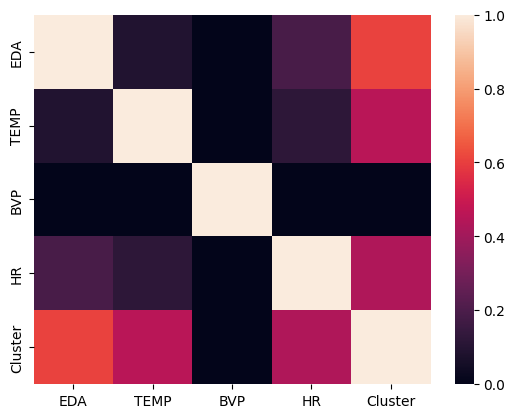

In [1]:
import pandas as pd
import seaborn as sns
import dask.dataframe as dd
import dask.array as da
from dask_ml.model_selection import train_test_split
from dask_ml.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from dask.distributed import Client
import xgboost as xgb

# Start a Dask client (optional but recommended for better performance)
client = Client()

# Load dataset
file_path = 'cluster_new_raw_test.csv'
df = pd.read_csv(file_path)
df.drop(columns=['id'], inplace=True)

# Visualize correlation matrix (in Pandas before converting to Dask)
sns.heatmap(df.corr())

# Convert to Dask DataFrame
df = dd.from_pandas(df, npartitions=3)

# Separate features and target variable
target_column = 'Cluster'
X = df.drop(columns=[target_column]).to_dask_array(lengths=True)
y = df[target_column].to_dask_array(lengths=True)

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Convert Dask arrays to DaskDMatrix, which is optimized for XGBoost with Dask
dtrain = xgb.dask.DaskDMatrix(client, X_train, y_train)
dtest = xgb.dask.DaskDMatrix(client, X_test, y_test)

# Set up parameters for XGBoost
params = {
    'objective': 'binary:logistic',  # Assuming binary classification
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'error'
}

# Train the model
output = xgb.dask.train(client, params, dtrain, num_boost_round=100)

# Make predictions
y_pred = xgb.dask.predict(client, output, dtest)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary

# Compute accuracy (convert Dask arrays to NumPy for metrics)
accuracy = accuracy_score(y_test.compute(), y_pred.compute())
print(f"Accuracy: {accuracy}")


In [3]:
import pandas as pd
import seaborn as sns
import dask.dataframe as dd
import dask.array as da
from dask_ml.model_selection import train_test_split, GridSearchCV
from dask_ml.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from dask.distributed import Client
import xgboost as xgb
from xgboost import XGBClassifier

In [4]:
file_path = 'cluster_new_raw_test.csv'
df = pd.read_csv(file_path)
df.drop(columns=['id'], inplace=True)
df.head()

,EDA,TEMP,BVP,HR,Cluster
0,0.563729,4.00,64.0,1.00,0
1,-0.000000,33.99,-0.0,83.00,0
2,0.382858,33.99,-0.0,83.00,1
3,0.438379,33.99,-0.0,75.33,1
4,0.414428,33.99,-0.0,70.50,1


In [5]:
y = df['Cluster']
y.value_counts()

Cluster
0    240871
1    210399
Name: count, dtype: int64

In [6]:
df = dd.from_pandas(df, npartitions=3)
# Inspect the dataset (optional)
df.head()

,EDA,TEMP,BVP,HR,Cluster
0,0.563729,4.00,64.0,1.00,0
1,-0.000000,33.99,-0.0,83.00,0
2,0.382858,33.99,-0.0,83.00,1
3,0.438379,33.99,-0.0,75.33,1
4,0.414428,33.99,-0.0,70.50,1


In [7]:
# Assume 'target' is the target variable and others are features
target_column = 'Cluster'
X = df.drop(columns=[target_column]).to_dask_array(lengths=True)
y = df[target_column].to_dask_array(lengths=True)

c:\Program Files\Python38\lib\site-packages\distributed\client.py:3108: UserWarning: Sending large graph of size 13.77 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
c:\Program Files\Python38\lib\site-packages\distributed\client.py:3108: UserWarning: Sending large graph of size 13.77 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [8]:
# Apply standardization
scaler = StandardScaler()
X = scaler.fit_transform(X)

c:\Program Files\Python38\lib\site-packages\distributed\client.py:3108: UserWarning: Sending large graph of size 13.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [13]:

# Define the parameter grid for hyperparameter tuning
param_grid = {

    'learning_rate': [0.01, 0.1, 0.2],            # Step size shrinkage used in updates
    'n_estimators': [50, 100, 200],               # Number of boosting rounds
    'max_depth': [3, 5, 7, 10],                   # Maximum tree depth for base learners
    'min_child_weight': [1, 5, 10],               # Minimum sum of instance weight(hessian) needed in a child
    'subsample': [0.6, 0.8, 1.0],                 # Fraction of samples used for fitting each base learner
    'colsample_bytree': [0.8, 1.0],               # Fraction of features to consider per tree
    'gamma': [0, 0.1, 0.3, 0.5],                  # Minimum loss reduction to make a further partition
    'reg_alpha': [0, 0.01, 0.1, 1],               # L1 regularization term on weights
    'reg_lambda': [1, 0.1, 0.01],                 # L2 regularization term on weights
    'scale_pos_weight': [1, 10, 25, 50]           # Balances positive and negative weights (useful for imbalanced data)
}



In [14]:

# Initialize the XGBoost classifier
model = XGBClassifier(
    objective='binary:logistic',  # For binary classification; adjust if multi-class
    tree_method='hist',           # Optimized for Dask; could also use 'gpu_hist' if GPU is available
    use_label_encoder=False,
    verbosity=1
)

model


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Set up the GridSearchCV with Dask
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Train the grid search on the training data
grid_search.fit(X_train, y_train)



c:\Program Files\Python38\lib\site-packages\distributed\client.py:3108: UserWarning: Sending large graph of size 13.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
c:\Program Files\Python38\lib\site-packages\distributed\client.py:3108: UserWarning: Sending large graph of size 42.05 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [ ]:
# Extract best model and evaluate on test data
best_model = grid_search.best_estimator_


In [ ]:
y_pred = best_model.predict(X_test)
y_pred

In [ ]:
accuracy = accuracy_score(y_test.compute(), y_pred.compute())
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy with Best Model: {accuracy}")